In [1]:
import os, sys
from glob import glob
from utils import p2r, stack_features, word2sense, regression, cv_regression_w2s, image_to_tensor, Subject, listdir
import numpy as np
from tqdm import tqdm

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from collections import OrderedDict 
import string

In [2]:
# Setup w2s
w2s_file = "ThingsWrd2Sns.txt"
_, w2s_embeddings = word2sense(w2s_file)
nDim = 2250

# Setup wordvec, sensevec
embedding_file = "sensevec_augmented_with_wordvec.csv"
f = open(embedding_file, 'r', encoding='utf-8')
senseveclines = f.readlines()
f.close()

embedding_file = "wordvec.csv"
f = open(embedding_file, 'r', encoding='utf-8')
wordveclines = f.readlines()
f.close()

# Cat's new word2vec (312 categories)
embedding_file = "ThingsWrd2Vec_subset.txt"
f = open(embedding_file, 'r', encoding='utf-8')
wordvec2lines = f.readlines()
f.close()

wordvec = {}
sensevec = {}
wordvec2 = {}

things = sorted(os.listdir('predicted_EVC_conv5'))

for i, thing in enumerate(things):
    if thing in w2s_embeddings:
        wordvec[thing] = wordveclines[i].split(',')
        wordvec[thing][-1] = wordvec[thing][-1].replace('\n', '')
        sensevec[thing] = senseveclines[i].split(',')
        sensevec[thing][-1] = sensevec[thing][-1].replace('\n', '')

# Wordvec without nan
wordvec_nonan = wordvec
nankeys = []
for wv in wordvec:
    ar = np.array(wordvec[wv])
    ar = ar.astype(np.float)
    if np.isnan(ar).any():
        nankeys.append(wv)

print(len(nankeys))  
 
for n in nankeys:
    del wordvec_nonan[n]

for wv in wordvec_nonan:
    wordvec_nonan[wv] = np.array(wordvec_nonan[wv]).astype(np.float)
    
print(len(wordvec_nonan.keys()))

# Wordvec filtered by CM
for i, wv2 in enumerate(wordvec2lines):
    if i == 0:
        continue
    word = (wordvec2lines[i].split(','))[0]
    if word in w2s_embeddings:
        wordvec2[word] = wordvec2lines[i].split(',')[1:]
        wordvec2[word][-1] = wordvec2[word][-1].replace('\n', '')

for wv in wordvec2:
    wordvec2[wv] = np.array(wordvec2[wv]).astype(np.float)
    

# Sensevec
for i, thing in enumerate(things):
    if thing in w2s_embeddings:
        sensevec[thing] = senseveclines[i].split(',')
        sensevec[thing][-1] = sensevec[thing][-1].replace('\n', '')
            
sensevec_nonan = sensevec
nankeys = []
for sv in sensevec:
    ar = np.array(sensevec[sv])
    ar = ar.astype(np.float)
    if np.isnan(ar).any():
        nankeys.append(sv)

print(nankeys)  
 
for n in nankeys:
    del sensevec_nonan[n]

for sv in sensevec_nonan:
    sensevec_nonan[sv] = np.array(sensevec_nonan[sv]).astype(np.float)
    
print(len(sensevec_nonan.keys()))

# Sensevec filtered to 312 categories
sensevec_filtered = {}

for i, wv2 in enumerate(wordvec2lines):
    if i == 0:
        continue
    word =  (wordvec2lines[i].split(','))[0]
    if word in sensevec.keys():
        sensevec_filtered[word] = sensevec[word]

# Wordvec (osf) filtered to 312 categories
wordvec_filtered = {}

for i, wv2 in enumerate(wordvec2lines):
    if i == 0:
        continue
    word =  (wordvec2lines[i].split(','))[0]
    if word in wordvec.keys():
        wordvec_filtered[word] = wordvec[word]
    
# dimensionality score
r_threshold = p2r(0.05/nDim, 1470)
r_threshold_wordvec = p2r(0.05/300, len(wordvec2lines)-1)

nPC = 7;

110
1360
['handcuff', 'paperweight', 'peppermint', 'pug', 'slime', 'teacup']
1464


In [3]:
# Stack data
rois = ['LOC', 'PPA', 'EVC'] 
layers = ['conv5', 'fc6'] #'conv1', 'conv5', 'fc6', 'conv1_r', 'conv5_r', 'fc6_r'
subjects = ['subj001/', 'subj002/', 'subj003/', 'subj004/'] #subj001/ , 'subj002/', 'subj003/', 'subj004/'
#random_subjects = ['subj001_random/', 'subj002_random/', 'subj003_random/', 'subj004_random/']

weighttype = ["real", "random"]
predictpath = {
    "real": "predicted1023/predicted/",
    "random": "predicted1026weight2/"
}

# Initialize r values
roi_r_set = {}
random_r_set = {}

# Permutation repeated many times
#perm_r_set = []
# for i in range(10, 100):
#     weighttype.append("perm" + str(i))
#     predictpath["perm" + str(i)] = "predicted1023/predictedperm" + str(i) + "/"
#     perm_r_set.append({})

# print(weighttype)
# print(predictpath)


for weight in weighttype:
    #if weight == "random":
    #    subjects = random_subjects
    #else:
    #    subjects = ['subj001/', 'subj002/', 'subj003/', 'subj004/']
    for roi in rois:
        roi_r = []
        for layer in layers:
            sub_voxel_regressor = {}

            for subj in subjects:
                path = predictpath[weight]
                fmri_path = path + subj + roi + "_" + layer
                fmri_path = os.path.join(os.getcwd(), fmri_path) 

                conditions = sorted(listdir(fmri_path))
                condition_voxels = {}
                for condition in conditions:
                    if condition.split('/')[-1] in w2s_embeddings.keys():
                        file_name = listdir((os.path.join(fmri_path, condition)))[0]
                        file_path = os.path.join(fmri_path, condition, file_name)
                        condition_voxels[condition] = np.load(file_path) 
                voxel_regressor = np.stack([condition_voxel for condition, condition_voxel in OrderedDict(condition_voxels).items()])
                sub_voxel_regressor[subj] = voxel_regressor

                #print(sub_voxel_regressor[subj].shape)
            all_voxel_regressor = np.hstack([sub_voxel_regressor[s] for s in subjects])
            #print(all_voxel_regressor.shape)

            for pc in tqdm(range(10, 80, 10), total=7, position=0, leave=True):
                _, voxel_mean_r = cv_regression_w2s(all_voxel_regressor, w2s_embeddings, fit=None, k=9, l2=0.0, pc=pc)
                roi_r.append(voxel_mean_r)

            #if subj == 'random/':
            #random_r_set[roi] = roi_r
            #else:
            if weight == "real":
                roi_r_set[roi] = roi_r
            elif weight == "random":
                random_r_set[roi] = roi_r
            elif "perm" in weight:
                i = int(weight.strip(string.ascii_letters))
                print(i)
                perm_r_set[i][roi] = roi_r

100%|██████████| 7/7 [00:18<00:00,  2.66s/it]


In [12]:
# #random_r_set = np.ndarray.tolist(np.load('results/random_r_set_face.npy', allow_pickle=True))
# #roi_r_set = np.ndarray.tolist(np.load('results/allsubj_r_set.npy', allow_pickle=True))
# #print(len(random_r_set['LOC']))
# perm_r_set = np.load('perm_r_set_60.npy', allow_pickle=True)

In [9]:
print(roi_r_set['LOC'][0])

NameError: name 'perm_r_set' is not defined

In [5]:
# Compute alternate metrics for semantic dimensionality score

roi_dim_set = {}
roi_max_set = {}
roi_mean_set = {}
roi_med_set = {}

for roi in rois:
    roi_dim = []
    roi_max = []
    roi_mean = []
    roi_med = []
    for dim_pred in roi_r_set[roi]:
        dim_pred = np.array(dim_pred)
        dim_pred_score = np.sum(dim_pred > r_threshold)
        dim_max = np.nanmax(dim_pred)
        dim_mean = np.nanmean(np.array(dim_pred))
        dim_med = np.nanmedian(np.array(dim_pred))
        roi_dim.append(dim_pred_score)
        roi_max.append(dim_max)
        roi_mean.append(dim_mean)
        roi_med.append(dim_med)
    roi_dim_set[roi] = roi_dim
    roi_max_set[roi] = roi_max
    roi_mean_set[roi] = roi_mean
    roi_med_set[roi] = roi_med

random_dim_set = {}
random_max_set = {}
random_mean_set = {}
random_med_set = {}

for roi in rois:
    random_dim = []
    random_max = []
    random_mean = []
    random_med = []
    for dim_pred in random_r_set[roi]:
        dim_pred = np.array(dim_pred)
        dim_pred_score = np.sum(dim_pred > r_threshold)
        dim_max = np.nanmax(dim_pred)
        dim_mean = np.nanmean(np.array(dim_pred))
        dim_med = np.nanmedian(np.array(dim_pred))
        random_dim.append(dim_pred_score)
        random_max.append(dim_max)
        random_mean.append(dim_mean)
        random_med.append(dim_med)
    random_dim_set[roi] = random_dim 
    random_max_set[roi] = random_max
    random_mean_set[roi] = random_mean
    random_med_set[roi] = random_med
    

TypeError: list indices must be integers or slices, not str

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


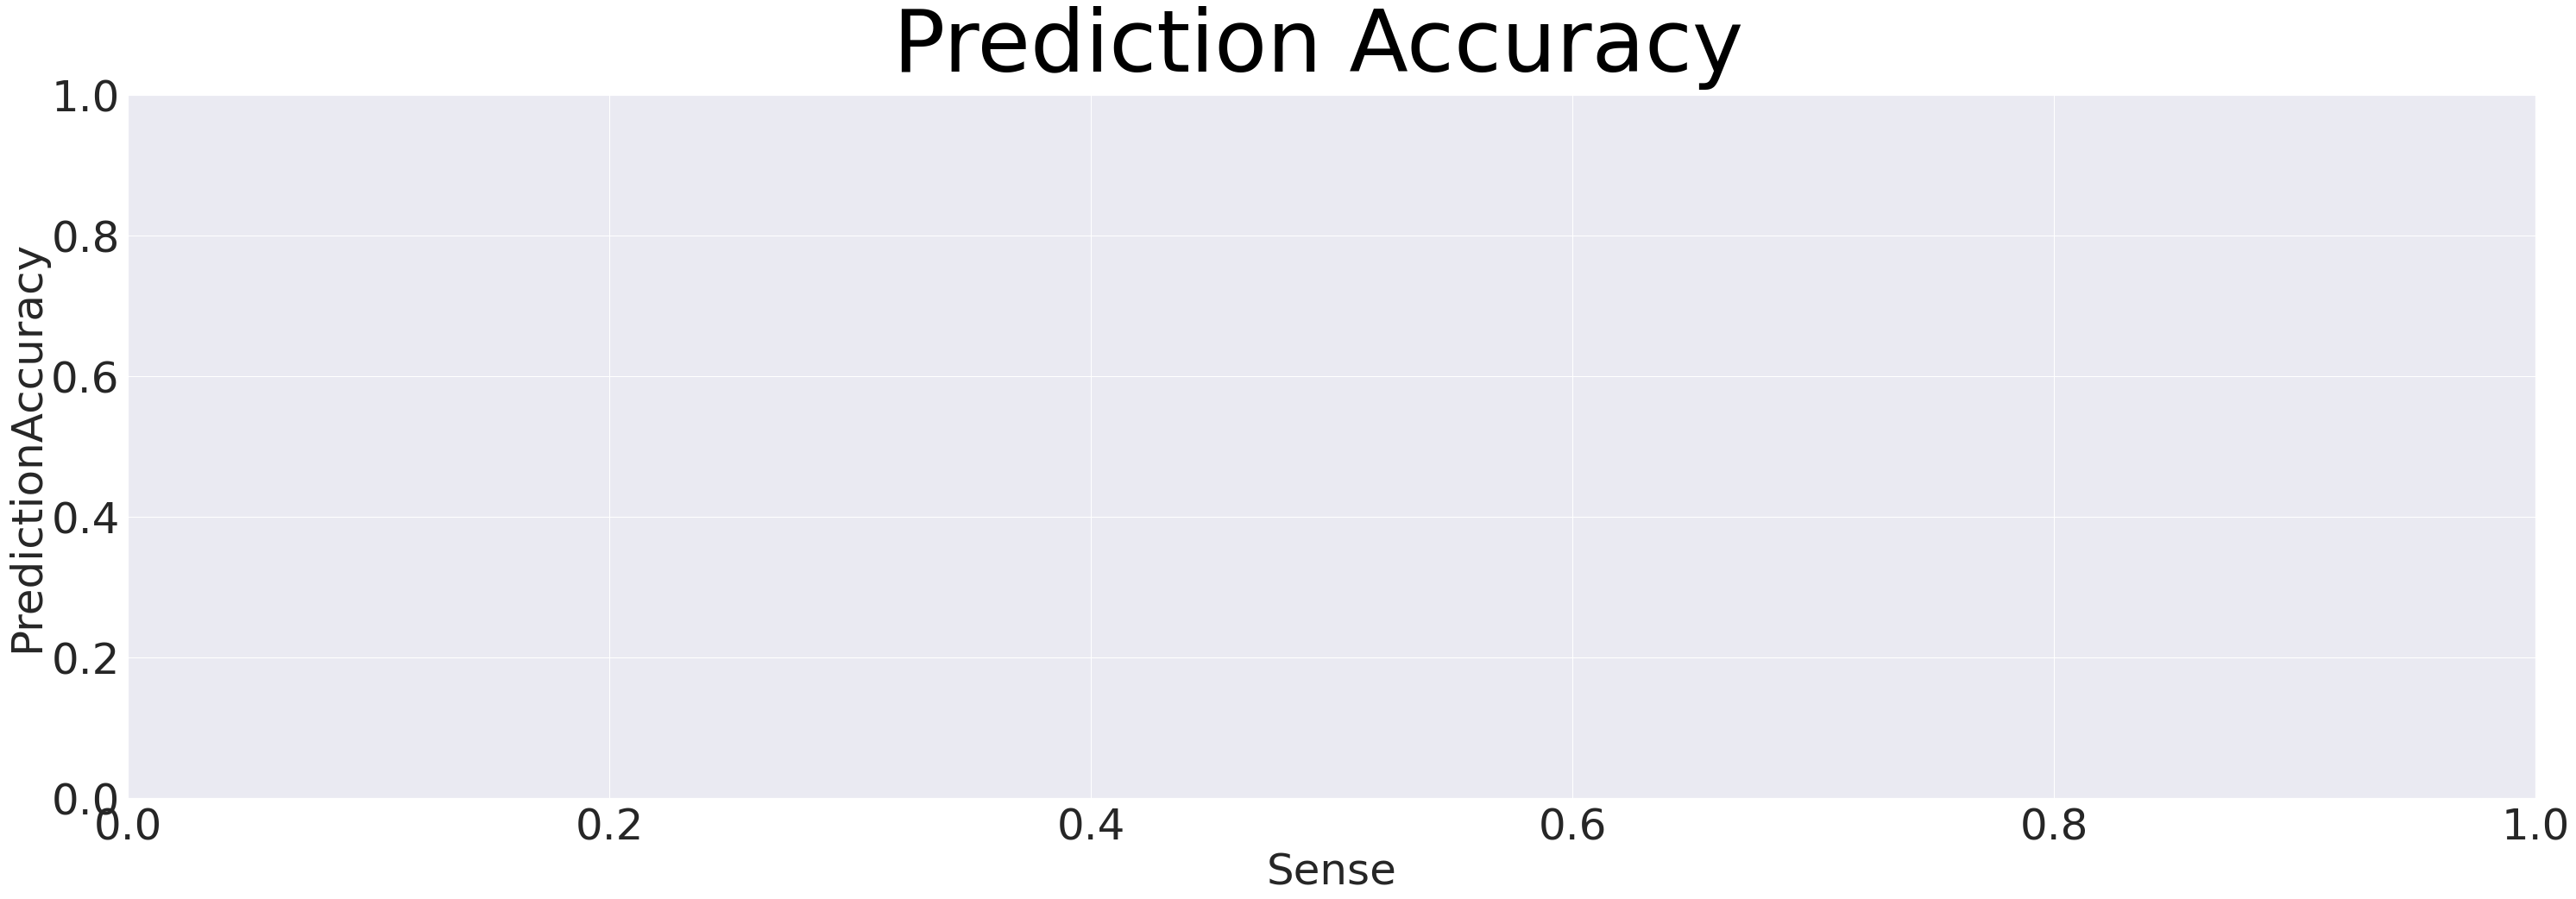

In [13]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

for pc in range(10, 80, nPC):
    plt.figure(figsize=(50,15))
    # Set the font dictionaries (for plot title and axis titles)
    title_font = {'fontname':'Arial', 'size':'100', 'color':'black', 'weight':'normal',
      'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    axis_font = {'fontname':'Arial', 'size':'50'}
    sns.set()
    #n= len(~np.isnan(mean_r))-1
    n= 2250-1

    #mean_r_nonan = mean_r[~np.isnan(mean_r)]
    #print(len(mean_r[~np.isnan(mean_r)]))
    ax = plt.subplot() # Defines ax variable by creating an empty plot
    # Set the tick labels font
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(50)
    plt.xlabel('Sense', **axis_font)
    plt.ylabel('PredictionAccuracy', **axis_font)
    plt.title("Prediction Accuracy ", **title_font)

    #Plot the Image!
    # plt.bar(range(0,n), np.sort(mean_r[0:n]), color = 'darkred')

    #plt.bar(range(0,2250), np.sort(mean_r_set[i])[::-1], color=cm.jet(1.*i/len(mean_r_set)), alpha=0.2)
    #plt.bar(range(0,2250), np.sort(mean_r_set[i])[::-1], color=cm.jet(1.*i/len(mean_r_set)), alpha=0.2)
    i = int(pc/10 - 1)
    
    plt.bar(range(0,2250), np.sort(perm_r_set['LOC'][i])[::-1], color='darkred', label='fMRI (LOC)', alpha=0.2)
    #plt.bar(range(0,300), np.sort(random_r_set['LOC'][i])[::-1], color='darkblue', label='fMRI (LOC) random', alpha=0.2)

    #plt.bar(range(0,300), np.sort(mean_r_feature_set[i])[::-1], color='darkblue', label='CNN features', alpha=0.2)

    plt.legend(prop={'size': 50})

    #ylim
    plt.ylim(-0.2, 0.6) 
    #save figure
    #plt.savefig('figures/SensePrediction_LOC_conv5_' + str(pc) + '.png')
    sns.reset_defaults()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


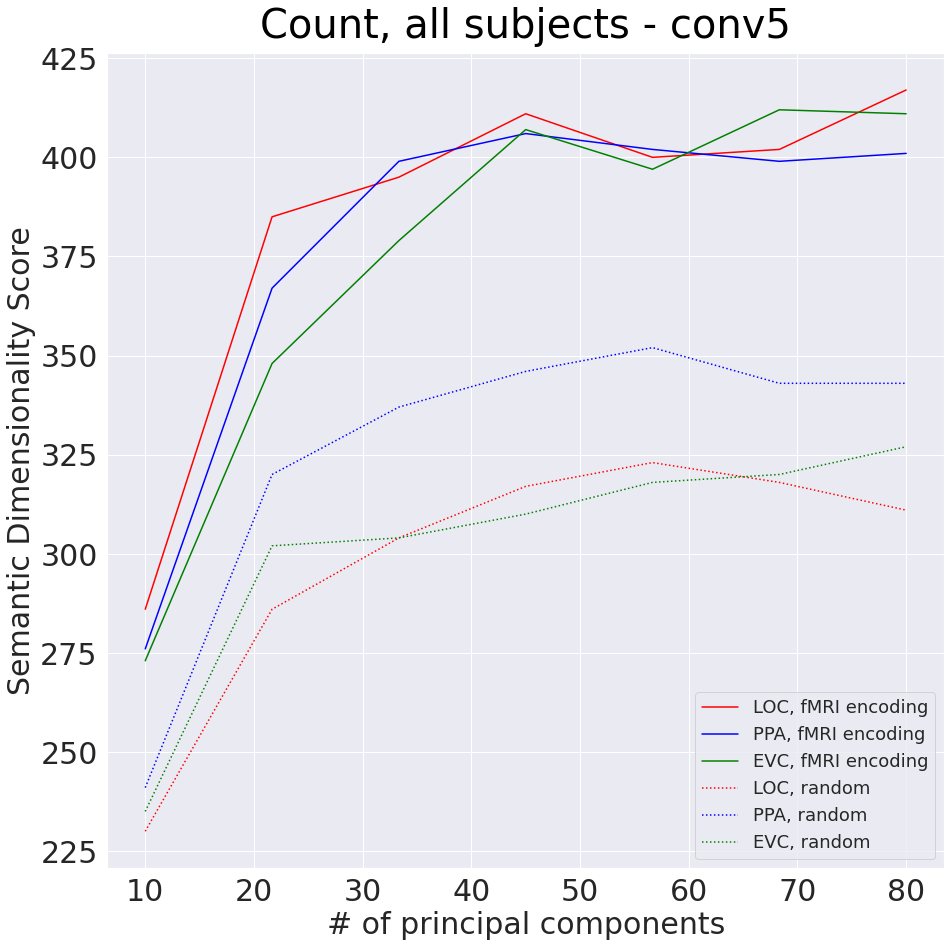

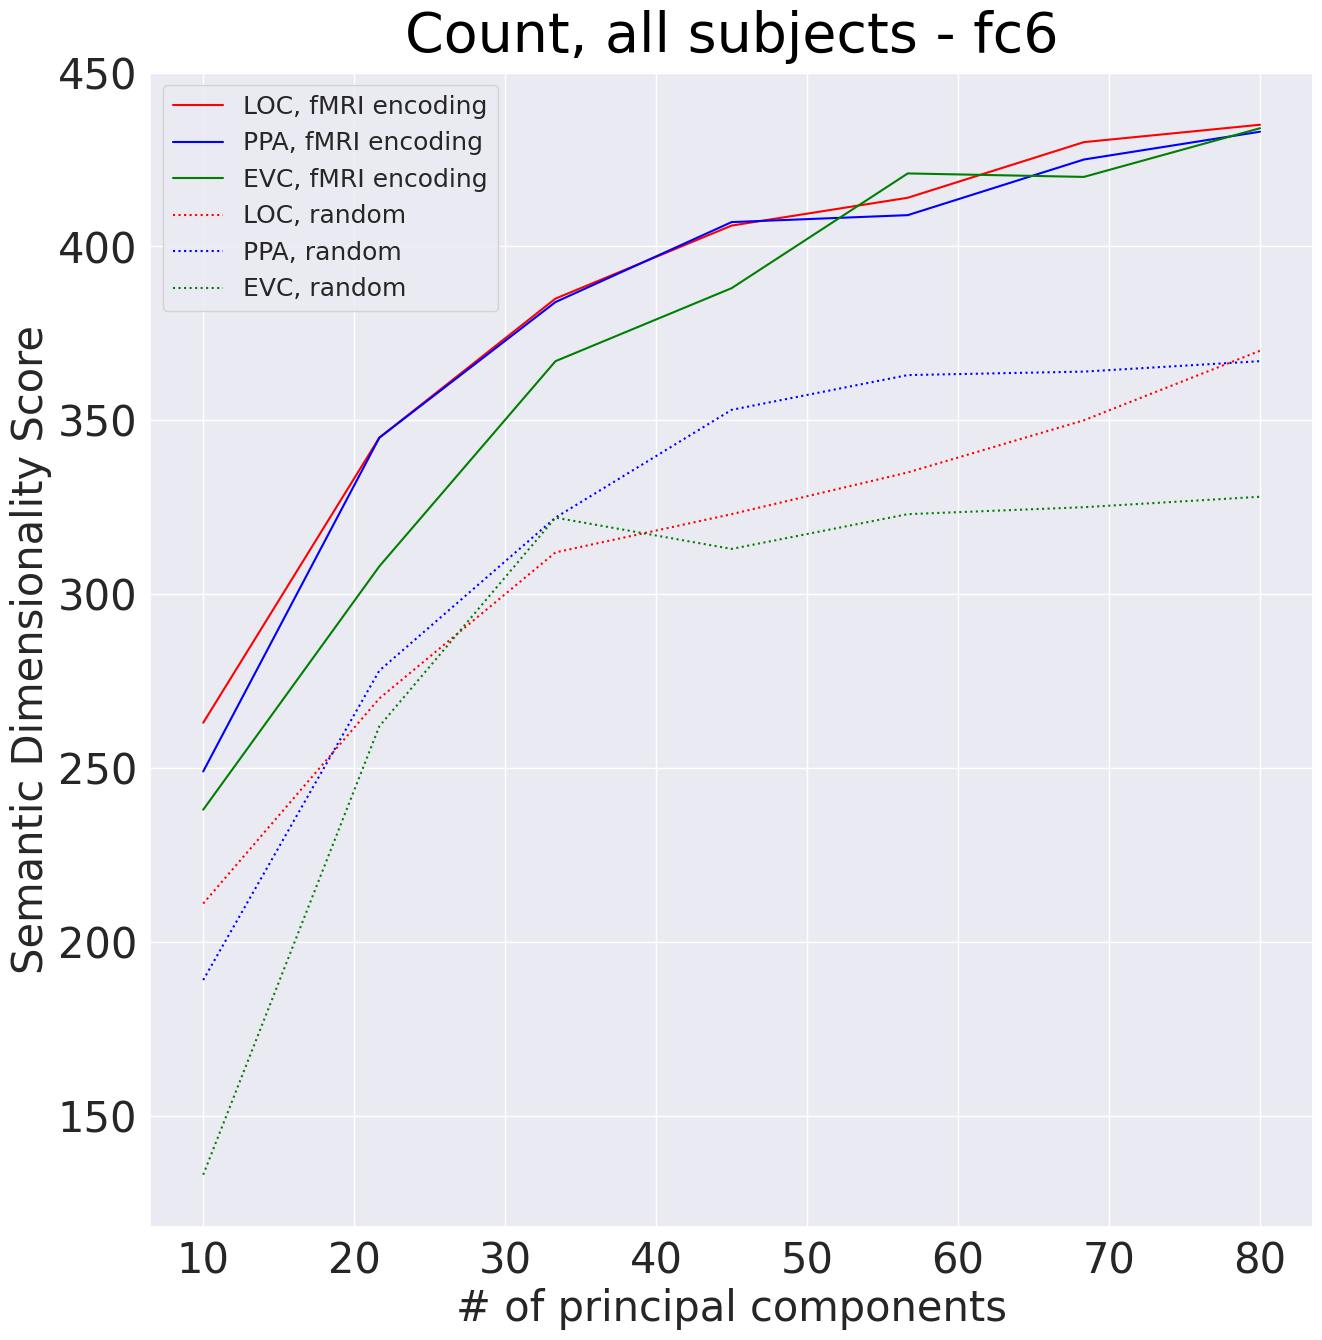

In [6]:
layeridx = {
    #"conv1": 0,
    #"conv5": 1,
    "conv5": 0,
    "fc6": 1,
    #"fc6": 1
}

for layer in layeridx:
    idx = layeridx[layer]
    x = np.linspace(10, 80, nPC)
    plt.figure(figsize=(15,15))

    title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
      'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    axis_font = {'fontname':'Arial', 'size':'30'}
    sns.set()

    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(30)
    plt.xlabel('# of principal components', **axis_font)
    plt.ylabel('Semantic Dimensionality Score', **axis_font)
    plt.title("Count, all subjects - " + layer, **title_font)

    plt.plot(x, roi_dim_set['LOC'][nPC*(idx):nPC*(idx+1)], '-', color='red', label='LOC, fMRI encoding')
    plt.plot(x, roi_dim_set['PPA'][nPC*(idx):nPC*(idx+1)], '-', color='blue', label='PPA, fMRI encoding')
    plt.plot(x, roi_dim_set['EVC'][nPC*(idx):nPC*(idx+1)], '-', color='green', label='EVC, fMRI encoding')
    #plt.plot(x, roi_dim_set['PFS'][nPC*idx:nPC*(idx+1)], '-', color='maroon', label='PFS, fMRI encoding')
    #plt.plot(x, roi_dim_set['LOCPFS'][nPC*idx:nPC*(idx+1)], '-', color='grey', label='LOC+PFS, fMRI encoding')

    plt.plot(x, random_dim_set['LOC'][nPC*idx:nPC*(idx+1)], ':', color='red', label='LOC, random')
    plt.plot(x, random_dim_set['PPA'][nPC*idx:nPC*(idx+1)], ':', color='blue', label='PPA, random')
    plt.plot(x, random_dim_set['EVC'][nPC*idx:nPC*(idx+1)], ':', color='green', label='EVC, random')
    #plt.plot(x, random_dim_set['PFS'][nPC*idx:nPC*(idx+1)], ':', color='maroon', label='PFS, random ')
    #plt.plot(x, random_dim_set['LOCPFS'][nPC*idx:nPC*(idx+1)], ':', color='grey', label='LOC+PFS, random')

    #plt.plot(x, roi_dim_set['FFA'][nPC*(idx):nPC*(idx+1)], '-', color='orange', label='FFA, fMRI encoding')
    #plt.plot(x, roi_dim_set['FFAOFASTS'][nPC*(idx):nPC*(idx+1)], '-', color='purple', label='FFAOFASTS, fMRI encoding')

    #plt.plot(x, random_dim_set['FFA'][nPC*idx:nPC*(idx+1)], ':', color='orange', label='FFA, random')
    #plt.plot(x, random_dim_set['FFAOFASTS'][nPC*idx:nPC*(idx+1)], ':', color='purple', label='FFAOFASTS, random')
    
    
    plt.legend(prop={'size': 18});

    #plt.savefig('figures0923/SemanticDimensionality_face_' + layer + '.png')
    sns.reset_defaults()

In [ ]:
layeridx = {
    "conv1": 0,
    "conv5": 1,
    "fc6": 2
}

for layer in layeridx:
    idx = layeridx[layer]
    x = np.linspace(10, 80, nPC)
    plt.figure(figsize=(15,15))

    title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
      'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    axis_font = {'fontname':'Arial', 'size':'30'}
    sns.set()

    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(30)
    plt.xlabel('# of principal components', **axis_font)
    #plt.ylabel('Semantic Dimensionality Score', **axis_font)
    plt.title("Max (All Subjects) - " + layer, **title_font)

    plt.plot(x, roi_max_set['LOC'][nPC*idx:nPC*(idx+1)], '-', color='red', label='LOC, fMRI encoding')
    plt.plot(x, roi_max_set['PPA'][nPC*idx:nPC*(idx+1)], '-', color='blue', label='PPA, fMRI encoding')
    plt.plot(x, roi_max_set['EVC'][nPC*idx:nPC*(idx+1)], '-', color='green', label='EVC, fMRI encoding')
    #plt.plot(x, roi_dim_set['PFS'][nPC*idx:nPC*(idx+1)], '-', color='maroon', label='PFS, fMRI encoding')
    plt.plot(x, roi_max_set['LOCPFS'][nPC*idx:nPC*(idx+1)], '-', color='grey', label='LOC+PFS, fMRI encoding')

    plt.plot(x, random_max_set['LOC'][nPC*idx:nPC*(idx+1)], ':', color='red', label='LOC, random')
    plt.plot(x, random_max_set['PPA'][nPC*idx:nPC*(idx+1)], ':', color='blue', label='PPA, random')
    plt.plot(x, random_max_set['EVC'][nPC*idx:nPC*(idx+1)], ':', color='green', label='EVC, random')
    #plt.plot(x, random_dim_set['PFS'][nPC*idx:nPC*(idx+1)], ':', color='maroon', label='PFS, random ')
    plt.plot(x, random_max_set['LOCPFS'][nPC*idx:nPC*(idx+1)], ':', color='grey', label='LOC+PFS, random')

    plt.legend(prop={'size': 18});

    plt.savefig('figures0923/SemanticDimensionality_max_allsubj' + layer + '.png')
    sns.reset_defaults()

In [ ]:
layeridx = {
    "conv1": 0,
    "conv5": 1,
    "fc6": 2
}

for layer in layeridx:
    idx = layeridx[layer]
    x = np.linspace(10, 80, nPC)
    plt.figure(figsize=(15,15))

    title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
      'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    axis_font = {'fontname':'Arial', 'size':'30'}
    sns.set()

    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(30)
    plt.xlabel('# of principal components', **axis_font)
    #plt.ylabel('Semantic Dimensionality Score', **axis_font)
    plt.title("Mean (All Subjects) - " + layer, **title_font)

    plt.plot(x, roi_mean_set['LOC'][nPC*idx:nPC*(idx+1)], '-', color='red', label='LOC, fMRI encoding')
    plt.plot(x, roi_mean_set['PPA'][nPC*idx:nPC*(idx+1)], '-', color='blue', label='PPA, fMRI encoding')
    plt.plot(x, roi_mean_set['EVC'][nPC*idx:nPC*(idx+1)], '-', color='green', label='EVC, fMRI encoding')
    #plt.plot(x, roi_dim_set['PFS'][nPC*idx:nPC*(idx+1)], '-', color='maroon', label='PFS, fMRI encoding')
    plt.plot(x, roi_mean_set['LOCPFS'][nPC*idx:nPC*(idx+1)], '-', color='grey', label='LOC+PFS, fMRI encoding')

    plt.plot(x, random_mean_set['LOC'][nPC*idx:nPC*(idx+1)], ':', color='red', label='LOC, random')
    plt.plot(x, random_mean_set['PPA'][nPC*idx:nPC*(idx+1)], ':', color='blue', label='PPA, random')
    plt.plot(x, random_mean_set['EVC'][nPC*idx:nPC*(idx+1)], ':', color='green', label='EVC, random')
    #plt.plot(x, random_dim_set['PFS'][nPC*idx:nPC*(idx+1)], ':', color='maroon', label='PFS, random ')
    plt.plot(x, random_mean_set['LOCPFS'][nPC*idx:nPC*(idx+1)], ':', color='grey', label='LOC+PFS, random')

    plt.legend(prop={'size': 18});

    plt.savefig('figures0923/SemanticDimensionality_mean_allsubj' + layer + '.png')
    sns.reset_defaults()

In [ ]:
layeridx = {
    "conv1": 0,
    "conv5": 1,
    "fc6": 2
}

for layer in layeridx:
    idx = layeridx[layer]
    x = np.linspace(10, 80, nPC)
    plt.figure(figsize=(15,15))

    title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
      'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    axis_font = {'fontname':'Arial', 'size':'30'}
    sns.set()

    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(30)
    plt.xlabel('# of principal components', **axis_font)
    #plt.ylabel('Semantic Dimensionality Score', **axis_font)
    plt.title("Median (All Subjects) - " + layer, **title_font)

    plt.plot(x, roi_med_set['LOC'][nPC*idx:nPC*(idx+1)], '-', color='red', label='LOC, fMRI encoding')
    plt.plot(x, roi_med_set['PPA'][nPC*idx:nPC*(idx+1)], '-', color='blue', label='PPA, fMRI encoding')
    plt.plot(x, roi_med_set['EVC'][nPC*idx:nPC*(idx+1)], '-', color='green', label='EVC, fMRI encoding')
    #plt.plot(x, roi_dim_set['PFS'][nPC*idx:nPC*(idx+1)], '-', color='maroon', label='PFS, fMRI encoding')
    plt.plot(x, roi_med_set['LOCPFS'][nPC*idx:nPC*(idx+1)], '-', color='grey', label='LOC+PFS, fMRI encoding')

    plt.plot(x, random_med_set['LOC'][nPC*idx:nPC*(idx+1)], ':', color='red', label='LOC, random')
    plt.plot(x, random_med_set['PPA'][nPC*idx:nPC*(idx+1)], ':', color='blue', label='PPA, random')
    plt.plot(x, random_med_set['EVC'][nPC*idx:nPC*(idx+1)], ':', color='green', label='EVC, random')
    #plt.plot(x, random_dim_set['PFS'][nPC*idx:nPC*(idx+1)], ':', color='maroon', label='PFS, random ')
    plt.plot(x, random_med_set['LOCPFS'][nPC*idx:nPC*(idx+1)], ':', color='grey', label='LOC+PFS, random')

    plt.legend(prop={'size': 18});

    plt.savefig('figures0923/SemanticDimensionality_median_allsubj' + layer + '.png')
    sns.reset_defaults()

In [ ]:
#print(roi_r_set['LOC'])
#print(roi_r_set['PPA'])
#print(roi_r_set['EVC'])
print(len(cnn_r_set))

np.save('02_dnn_r_pca', cnn_r_set)
#np.save('cnn_random_set_pca', cnn_random_r_set)

#roi_r_set = np.load('roi_r_set_pca')
#cnn_r_set = np.load('cnn_r_set_pca')
#np.save('roi_r_subj1_all_pca', roi_r_set)
#np.save('cnn_pretrained_r_pca', cnn_r_set)


In [ ]:

for i in range(9):
    plt.figure(figsize=(50,35))
    title_font = {'fontname':'Arial', 'size':'100', 'color':'black', 'weight':'normal',
      'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    axis_font = {'fontname':'Arial', 'size':'100'}
    sns.set()

    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(100)
    plt.xlabel('Sense', **axis_font)
    plt.ylabel('PredictionAccuracy', **axis_font)
    plt.title("Prediction Accuracy ", **title_font)

    #plt.bar(range(0,nDim), np.sort(roi_r_set[roi][0])[::-1], color='b', label=roi + '_conv1', alpha=0.5)
    plt.bar(range(0,nDim), np.sort(cnn_r_set[i])[::-1], color='g', label='0', alpha=0.5)
    plt.bar(range(0,nDim), np.sort(cnn_r_set[i+9])[::-1], color='r', label='9', alpha=0.5)
    plt.bar(range(0,nDim), np.sort(cnn_r_set[i+9*2])[::-1], color='c', label='8', alpha=0.5)

    #plt.bar(range(0,nDim), np.sort(cnn_mean_r)[::-1], color='darkblue', label='CNN features', alpha=0.2)
    plt.legend(prop={'size': 100})
    plt.ylim(-0.2, 0.6) 

    #plt.savefig('figures/Subj1_noPCA_' + roi + '.png')

    sns.reset_defaults()

In [ ]:
roi = 'LOC'

for pc in range(10, 100, 10):
    plt.figure(figsize=(50,35))
    title_font = {'fontname':'Arial', 'size':'100', 'color':'black', 'weight':'normal',
      'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    axis_font = {'fontname':'Arial', 'size':'100'}
    sns.set()

    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(100)
    plt.xlabel('Sense', **axis_font)
    plt.ylabel('PredictionAccuracy', **axis_font)
    plt.title("Prediction Accuracy ", **title_font)

    i = int(pc/10) - 1
    plt.bar(range(0,nDim), np.sort(roi_r_set[roi][i])[::-1], color='darkred', label='fMRI (LOC)', alpha=0.2)
    #plt.bar(range(0,nDim), np.sort(cnn_r_set[i])[::-1], color='darkblue', label='CNN features', alpha=0.2)

    plt.legend(prop={'size': 100})
    plt.ylim(-0.2, 0.6) 
    
    #save figure
    #plt.savefig('figures/SensePrediction_LOC_conv5_reproduced' + str(pc) + '.png')
    
    sns.reset_defaults()

In [ ]:
#roi_r_set = np.load('02_roi_r_subj1_pca.npy', allow_pickle=True)
dnn_r_set = np.load('02_dnn_r_pca.npy', allow_pickle=True)
#roi_r_set = np.ndarray.tolist(roi_r_set)


#roi_dim_set = {}
cnn_dim_set = []

# for roi in rois:
#     roi_dim = []
#     for dim_pred in roi_r_set[roi]:
#         dim_pred = np.array(dim_pred)
#         dim_pred_score = np.sum(dim_pred > r_threshold)
#         roi_dim.append(dim_pred_score)
#     roi_dim_set[roi] = roi_dim
    
for dim_pred in cnn_r_set:
    dim_pred = np.array(dim_pred)
    dim_pred_score = np.sum(dim_pred > r_threshold)
    cnn_dim_set.append(dim_pred_score)


In [ ]:
# CONV1

x = np.linspace(10, 100, 9)
plt.figure(figsize=(15,15))

title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'30'}
sns.set()

ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(30)
plt.xlabel('# of principal components', **axis_font)
plt.ylabel('Semantic Dimensionality Score', **axis_font)
plt.title("PC-Matched Semantic Dimensionality (Subj1, Conv1)", **title_font)

plt.plot(x, roi_dim_set['LOC'][0:9], '-', color='darkorange', label='LOC - Conv1')
#plt.plot(x, roi_dim_set['LOC'][9*2:9*3], '--', color='orange', label='LOC - Fc6')
plt.plot(x, roi_dim_set['LOC'][9*3:9*4], '--', color='tan', label='LOC - Conv1 random')
#plt.plot(x, roi_dim_set['LOC'][9*5:9*6], '--', color='moccasin', label='LOC - Fc6 random')

plt.plot(x, roi_dim_set['PPA'][0:9], '-', color='forestgreen', label='PPA - Conv1')
#plt.plot(x, roi_dim_set['PPA'][9*2:9*3], '--', color='limegreen', label='PPA - Fc6')
plt.plot(x, roi_dim_set['PPA'][9*3:9*4], '--', color='seagreen', label='PPA - Conv1 random')
#plt.plot(x, roi_dim_set['PPA'][9*5:9*6], '--', color='mediumseagreen', label='PPA - Fc6 random')

plt.plot(x, roi_dim_set['EVC'][0:9], '-', color='blue', label='EVC - Conv1')
#plt.plot(x, roi_dim_set['EVC'][9*2:9*3], '--', color='darkblue', label='EVC - Fc6')
plt.plot(x, roi_dim_set['EVC'][9*3:9*4], '--', color='darkslateblue', label='EVC - Conv1 random')
#plt.plot(x, roi_dim_set['EVC'][9*5:9*6], '--', color='slateblue', label='EVC - Fc6 random')

plt.plot(x, cnn_dim_set[0:9], '-r', label='CNN - Conv1')
#plt.plot(x, cnn_dim_set[9:9*2], '--', color='fuchsia', label='CNN - Fc6')
plt.plot(x, cnn_dim_set[9*3:9*4], ':', color='firebrick', label='CNN - Conv1 random')
#plt.plot(x, cnn_dim_set[9*3:9*4], '--', color='pink', label='CNN - Fc6 random')

plt.legend(prop={'size': 18});

plt.savefig('figures/SemanticDimensionality_Conv1' + '.png')
sns.reset_defaults()


In [ ]:
# CONV5

x = np.linspace(10, 100, 9)
plt.figure(figsize=(15,15))

title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'30'}
sns.set()

ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(30)
plt.xlabel('# of principal components', **axis_font)
plt.ylabel('Semantic Dimensionality Score', **axis_font)
plt.title("PC-Matched Semantic Dimensionality (Subj1, Conv5)", **title_font)

plt.plot(x, roi_dim_set['LOC'][9:9*2], '-', color='darkorange', label='LOC - Conv5')
#plt.plot(x, roi_dim_set['LOC'][9*2:9*3], '--', color='orange', label='LOC - Fc6')
plt.plot(x, roi_dim_set['LOC'][9*4:9*5], '--', color='tan', label='LOC - Conv5 random')
#plt.plot(x, roi_dim_set['LOC'][9*5:9*6], '--', color='moccasin', label='LOC - Fc6 random')

plt.plot(x, roi_dim_set['PPA'][9:9*2], '-', color='forestgreen', label='PPA - Conv5')
#plt.plot(x, roi_dim_set['PPA'][9*2:9*3], '--', color='limegreen', label='PPA - Fc6')
plt.plot(x, roi_dim_set['PPA'][9*4:9*5], '--', color='seagreen', label='PPA - Conv5 random')
#plt.plot(x, roi_dim_set['PPA'][9*5:9*6], '--', color='mediumseagreen', label='PPA - Fc6 random')

plt.plot(x, roi_dim_set['EVC'][9:9*2], '-', color='blue', label='EVC - Conv5')
#plt.plot(x, roi_dim_set['EVC'][9*2:9*3], '--', color='darkblue', label='EVC - Fc6')
plt.plot(x, roi_dim_set['EVC'][9*4:9*5], '--', color='darkslateblue', label='EVC - Conv5 random')
#plt.plot(x, roi_dim_set['EVC'][9*5:9*6], '--', color='slateblue', label='EVC - Fc6 random')

plt.plot(x, cnn_dim_set[9:9*2], '-r', label='CNN - Conv5')
#plt.plot(x, cnn_dim_set[9:9*2], '--', color='fuchsia', label='CNN - Fc6')
plt.plot(x, cnn_dim_set[9*4:9*5], ':', color='firebrick', label='CNN - Conv5 random')
#plt.plot(x, cnn_dim_set[9*3:9*4], '--', color='pink', label='CNN - Fc6 random')

plt.legend(prop={'size': 18});

plt.savefig('figures/SemanticDimensionality_Conv5' + '.png')
sns.reset_defaults()


In [ ]:

# FC6

x = np.linspace(10, 100, 9)
plt.figure(figsize=(15,15))

title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'30'}
sns.set()

ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(30)
plt.xlabel('# of principal components', **axis_font)
plt.ylabel('Semantic Dimensionality Score', **axis_font)
plt.title("PC-Matched Semantic Dimensionality (Subj1, FC6)", **title_font)


x = np.linspace(10, 100, 9)
#plt.plot(x, roi_dim_set['LOC'][9:9*2], '--', color='darkorange', label='LOC - Conv5')
plt.plot(x, roi_dim_set['LOC'][9*2:9*3], '-', color='orange', label='LOC - Fc6')
#plt.plot(x, roi_dim_set['LOC'][9*4:9*5], '--', color='tan', label='LOC - Conv5 random')
plt.plot(x, roi_dim_set['LOC'][9*5:9*6], '--', color='moccasin', label='LOC - Fc6 random')

#plt.plot(x, roi_dim_set['PPA'][9:9*2], '--', color='forestgreen', label='PPA - Conv5')
plt.plot(x, roi_dim_set['PPA'][9*2:9*3], '-', color='limegreen', label='PPA - Fc6')
#plt.plot(x, roi_dim_set['PPA'][9*4:9*5], '--', color='seagreen', label='PPA - Conv5 random')
plt.plot(x, roi_dim_set['PPA'][9*5:9*6], '--', color='mediumseagreen', label='PPA - Fc6 random')

#plt.plot(x, roi_dim_set['EVC'][9:9*2], '--', color='blue', label='EVC - Conv5')
plt.plot(x, roi_dim_set['EVC'][9*2:9*3], '-', color='darkblue', label='EVC - Fc6')
#plt.plot(x, roi_dim_set['EVC'][9*4:9*5], '--', color='darkslateblue', label='EVC - Conv5 random')
plt.plot(x, roi_dim_set['EVC'][9*5:9*6], '--', color='slateblue', label='EVC - Fc6 random')

#plt.plot(x, cnn_dim_set[0:9], '--r', label='CNN - Conv5')
plt.plot(x, cnn_dim_set[9:9*2], '-', color='fuchsia', label='CNN - Fc6')
#plt.plot(x, cnn_dim_set[9*2:9*3], '--', color='firebrick', label='CNN - Conv5 random')
plt.plot(x, cnn_dim_set[9*5:9*6], ':', color='palevioletred', label='CNN - Fc6 random')

plt.legend(prop={'size': 18});

plt.savefig('figures/SemanticDimensionality_Fc6' + '.png')
sns.reset_defaults()

In [ ]:
r_threshold = p2r(0.05/nDim, 1470)
print(r_threshold)

In [ ]:
fmri_mean = np.mean(train_voxels, axis=0)
fmri_cov = np.cov(train_voxels, rowvar=False)

train_voxels_rand = np.random.multivariate_normal(fmri_mean, fmri_cov, (train_voxels.shape[0]))
test_voxels_rand = np.random.multivariate_normal(fmri_mean, fmri_cov, (test_voxels.shape[0]))


roi_r_random_set = {}
for roi in rois:
    roi_r = []
    for layer in layers:
        
        fmri_path = "predicted/" + subj + roi + "_" + layer
        fmri_path = os.path.join(os.getcwd(), fmri_path) 
        voxel_regressor = stack_features(fmri_path, fmri=True)

        for pc in tqdm(range(10, 100, 10), total=9, position=0, leave=True):
            voxel_mean_r = cv_regression_w2s(voxel_regressor, w2s_embeddings, fit=None, k=9, l2=0.0, pc=pc)
            roi_r.append(voxel_mean_r)

        roi_r_set[roi] = roi_r
    
cnn_mean_r = cv_regression_w2s(cnn_regressor, w2s_embeddings, fit=None, k=9, l2=0.0, pc=None)

In [ ]:
# Best predicted dimensions
from train import mean_condition_features
from feature_extractors import AlexNetConv1, AlexNetConv5, AlexNetFC6

#condition_features = stack_features('features_fc6.pth', fmri=False)
#feat_extractor = AlexNetConv5()
#condition_features = mean_condition_features(feat_extractor, 256)
#print(condition_features.shape) #1470, 4096 -> 81, 4096
#feature_mean_r = cv_regression_w2s(condition_features, w2s_embeddings, fit=None, k=9, l2=0.0, pc=10)
#maxdim_fc6 = feature_mean_r.argsort()[-10:][::-1]

#condition_features = stack_features('features_conv5.pth', fmri=False)

condition_features = stack_features('./predictedww/subj001/EVC_fc6', fmri=True)

In [ ]:
weights, feature_mean_r = cv_regression_w2s(condition_features, w2s_embeddings, fit=None, k=9, l2=0.0, pc=None)
maxdim_conv5 = feature_mean_r.argsort()[-20:][::-1]

In [ ]:

print("{:.4f}".format(w2s_embeddings['puck'][213]));
print("{:.4f}".format(w2s_embeddings['ant'][213]));
print("{:.4f}".format(w2s_embeddings['airplane'][213]));


In [ ]:
print(weights.shape)
print(condition_features.shape)
predicted = np.matmul(condition_features, weights.T)
print(predicted.shape)

In [ ]:
for topDim in range(20):
    x = []
    y = []
    for i, thing in enumerate(w2s_embeddings):
        x.append(w2s_embeddings[thing][maxdim_conv5[topDim]])
        y.append(predicted[i][maxdim_conv5[topDim]])

    plt.figure(figsize=(15,15))

    title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
      'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    axis_font = {'fontname':'Arial', 'size':'30'}
    sns.set()

    ax = plt.subplot() 
    plt.xlabel('Actual embedding value', **axis_font)
    plt.ylabel('Predicted embedding value', **axis_font)
    plt.title("Correlation for top predicted dimension: " + str(feature_mean_r[maxdim_conv5][topDim]) + ', ' + str(maxdim_conv5[topDim]), **title_font)

    ax.scatter(x, y)

    for i, thing in enumerate(w2s_embeddings):
        #ax.annotate(thing, (x[i], y[i]))
        plt.plot(x[i], y[i])
        plt.text(x[i], y[i], thing)


In [ ]:
top = np.array(w2s_embeddings['hyena']).argsort()[-20:][::-1]
print(np.array(w2s_embeddings['hyena'])[top])

In [ ]:
import torch 

conditions = listdir('images')
condition_features = {}
feat_extractor = AlexNetConv5()

for c in conditions:
    c_name = c.split('/')[-1]
    if c_name in wordvec2:
        stimuli = listdir(c)
        stimuli = [image_to_tensor(s, resolution=256) for s in stimuli]
        stimuli = torch.stack(stimuli) # stacked in 10
        #if torch.cuda.is_available():
        #    stimuli = stimuli.cuda()
        with torch.no_grad():
            feats = feat_extractor(stimuli).mean(dim=0).cpu().numpy()
        condition_features[c_name] = feats

condition_features = np.stack([condition_feat for condition, condition_feat in OrderedDict(condition_features).items()])
print(condition_features.shape)

weights, feature_mean_r = cv_regression_w2s(condition_features, wordvec2, fit=None, k=9, l2=0.0, pc=None)
maxdim_conv5 = feature_mean_r.argsort()[-20:][::-1]

In [ ]:
print(feature_mean_r[maxdim_conv5])

In [ ]:
print(weights.shape)
print(condition_features.shape)
predicted = np.matmul(condition_features, weights.T)
print(predicted.shape)

for topDim in range(20):
    x = []
    y = []
    for i, thing in enumerate(wordvec2):
        x.append(wordvec2[thing][maxdim_conv5[topDim]])
        y.append(predicted[i][maxdim_conv5[topDim]])

    plt.figure(figsize=(15,15))

    title_font = {'fontname':'Arial', 'size':'40', 'color':'black', 'weight':'normal',
      'verticalalignment':'bottom'} # Bottom vertical alignment for more space
    axis_font = {'fontname':'Arial', 'size':'30'}
    sns.set()

    ax = plt.subplot() 
    plt.xlabel('Actual embedding value', **axis_font)
    plt.ylabel('Predicted embedding value', **axis_font)
    plt.title("Correlation for top predicted dimension: " + str(topDim) + ', ' + str(maxdim_conv5[topDim]), **title_font)

    ax.scatter(x, y)

    for i, thing in enumerate(wordvec2):
        #ax.annotate(thing, (x[i], y[i]))
        plt.plot(x[i], y[i])
        plt.text(x[i], y[i], thing)

        
        